# Computation of the vanishing derivatives pre-certificate for radial images in the Gaussian deconvolution setting

This notebook allows to reproduce the experiments presented in the Section 5.3.2 of

Y. De Castro, V. Duval, R. Petit, exact recovery of the support of piecewise constant images via total variation regularization, preprint, 2023

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from math import pi, sqrt, exp, sin, cos
from scipy.special import jv
from scipy.integrate import quad, dblquad
from matplotlib import rc
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

import warnings
warnings.filterwarnings('ignore')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)

In [2]:
π = pi

We define the Fourier transforms of $h:x\mapsto \mathrm{exp}(-\|x\|^2/(2\sigma^2))$, $f_R=h\star\mathbf{1}_{B(0,R)}$ and $g_R=h\star\mathcal{H}^1_{\partial B(0,R)}$.

In [3]:
def h_hat(ρ, σ):
    return 2*π*σ**2 * exp(-σ**2 * ρ**2 / 2)

def ind_ball_hat(ρ, r):
    return 2*π*r * jv(1, r*ρ) / ρ

def ind_circle_hat(ρ, r):
    return 2*π*r * jv(0, r*ρ)

def f_hat(ρ, r, σ):
    return h_hat(ρ, σ) * ind_ball_hat(ρ, r)

def g_hat(ρ, r, σ):
    return h_hat(ρ, σ) * ind_circle_hat(ρ, r)

We check that: $\pi R^2=\langle \mathbf{1}_{B(0,R)},\mathbf{1}_{B(0,R)}\rangle=\frac{1}{(2\pi)^2}\langle \mathcal{F}\mathbf{1}_{B(0,R)},\mathcal{F}\mathbf{1}_{B(0,R)}\rangle$

In [4]:
r = 0.5
print("should be approximately {}:".format(π*r**2))
print(quad(lambda ρ: 2*π * ρ * ind_ball_hat(ρ, r) * ind_ball_hat(ρ, r), 0, np.inf)[0]/(2*π)**2)

should be approximately 0.7853981633974483:
0.7856120377200123


We will need to compute $\langle f_{R_1},f_{R_2}\rangle$, $\langle g_{R_1},g_{R_2}\rangle$ and $\langle f_{R_1},g_{R_2}\rangle$. We use $\langle f,g\rangle=\frac{1}{(2\pi)^2}\langle \hat{f},\hat{g}\rangle$.

In [5]:
def inner_prod_f(r_1, r_2, σ):
    val, _ = quad(lambda ρ: f_hat(ρ, r_1, σ) * f_hat(ρ, r_2, σ) * ρ, 0, np.inf)
    return val / (2*π)

def inner_prod_g(r_1, r_2, σ):
    val, _ = quad(lambda ρ: g_hat(ρ, r_1, σ) * g_hat(ρ, r_2, σ) * ρ, 0, np.inf)
    return val / (2*π)

def inner_prod_fg(r_1, r_2, σ):
    val, _ = quad(lambda ρ: f_hat(ρ, r_1, σ) * g_hat(ρ, r_2, σ) * ρ, 0, np.inf)
    return val / (2*π)

We look for $p$ with minimal norm satisfying $\langle p,f_{R_i}\rangle =\epsilon_i P(E_i)$ and $\langle p,g_{R_i}\rangle=\epsilon_i 2\pi$ for all $i\in\{1,...,N\}$.

We therefore have $p=\Gamma_E^*\begin{pmatrix}a\\b\end{pmatrix}$ with $\begin{pmatrix}a\\b\end{pmatrix}=(\Gamma_E^*\Gamma_E)^{-1}\begin{pmatrix}(\epsilon_i P(E_i))_{i=1}^N\\(\epsilon_i2\pi)_{i=1}^N\end{pmatrix}$

We compute $A=\Gamma_E^*\Gamma_E$.

In [6]:
def compute_A(r_tab, σ):
    n = len(r_tab)
    res = np.zeros((2*n, 2*n))
    
    for i in range(n):
        for j in range(n):
            res[i, j] = inner_prod_f(r_tab[i], r_tab[j], σ)
            
    for i in range(n):
        for j in range(n):
            res[n+i, n+j] = inner_prod_g(r_tab[i], r_tab[j], σ)
            
    for i in range(n):
        for j in range(n):
            aux = inner_prod_fg(r_tab[j], r_tab[i], σ)
            res[n+i, j] = aux
            
    for i in range(n):
        for j in range(n):
            aux = inner_prod_fg(r_tab[i], r_tab[j], σ)
            res[i, n+j] = aux        
    
    return res

def compute_ab(r_tab, ϵ_tab, σ):
    n = len(r_tab)
    b = np.zeros(2*n)
    
    for i in range(n):
        b[i] = ϵ_tab[i] * 2*π*r_tab[i]
        b[n+i] = ϵ_tab[i] * 2*π
    
    A = compute_A(r_tab, σ)
    
    return np.linalg.solve(A, b)

We have $\eta=h\star p=\sum\limits_{i=1}^N a_i \eta_{1,i}+b_i\eta_{2,i}$ with $\eta_{1,i}=h\star f_{R_i}=h\star h\star \mathbf{1}_{B(0,R)}$ and $\eta_{2,i}=h\star g_{R_i}=h\star h\star \mathcal{H}^1_{\partial B(0,R)}$. 
 
We also have
 $$(\varphi_{\sigma}\star\varphi_{\sigma})=\pi\sigma^2\varphi_{\sqrt{2}\sigma}\,.$$

In [7]:
def h(x, σ):
    return exp(-(x[0]**2 + x[1]**2) / (2*σ**2))

def η1(x, r, σ):
    val, _ = dblquad(lambda θ, ρ: ρ * h(x - np.array([ρ*cos(θ), ρ*sin(θ)]), sqrt(2)*σ), 0, r, 0, 2*π)
    return val * (π*σ**2)

def η2(x, r, σ):
    val, _ = quad(lambda θ: h(x - np.array([r*cos(θ), r*sin(θ)]), sqrt(2)*σ), 0, 2*π)
    return val * r * (π*σ**2)

### Plot of $\eta_1$ and $\eta_2$ for $N=1$, $R_1=1.2$, $a_1=1$ and $\sigma=0.2$

In [8]:
r_1 = 1.2
σ = 0.2

In [9]:
x, y = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z1 = np.array([[η1(np.array([X[i, j], Y[i, j]]), r_1, σ) for j in range(X.shape[1])]
               for i in range(X.shape[0])])
Z2 = np.array([[η2(np.array([X[i, j], Y[i, j]]), r_1, σ) for j in range(X.shape[1])]
               for i in range(X.shape[0])])

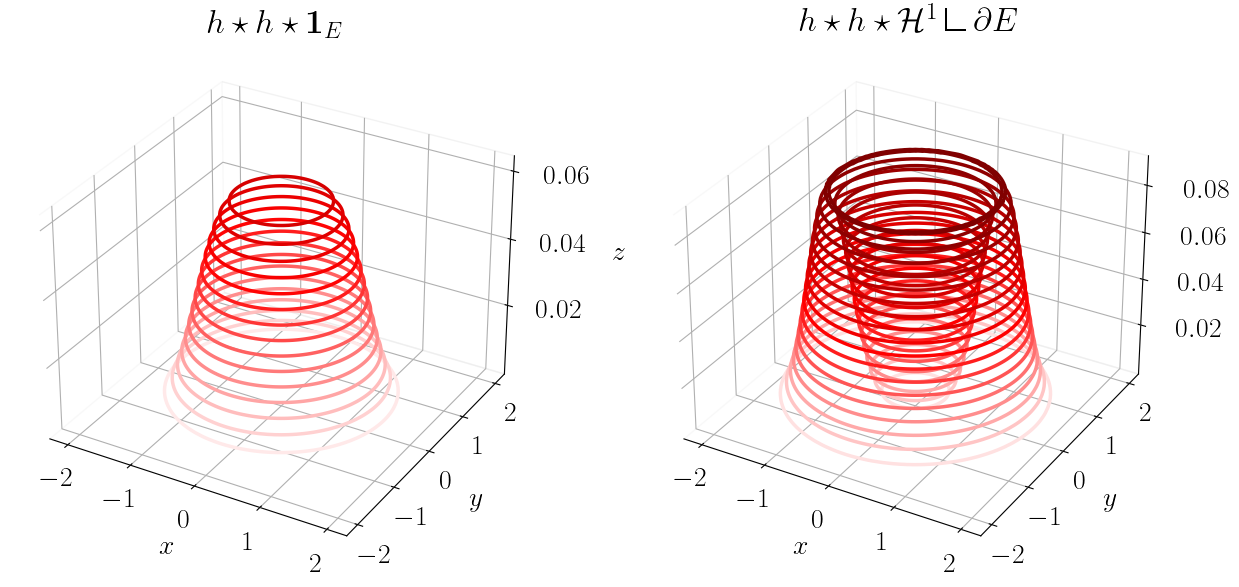

In [10]:
fig = plt.figure(figsize=(15, 21))

v_abs_max = max(np.max(np.abs(Z1)), np.max(np.abs(Z2)))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
im = ax1.contour3D(X, Y, Z1, 20, cmap='seismic', vmin=-v_abs_max, vmax=v_abs_max, linewidths=2.5)
ax1.set_xlabel(r'$x$', labelpad=10)
ax1.set_ylabel(r'$y$', labelpad=10)
ax1.set_zlabel(r'$z$', labelpad=28)
ax1.set_title(r'$h\star h\star \mathbf{1}_E$')
ax1.tick_params(axis='z', which='major', pad=15)
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
im = ax2.contour3D(X, Y, Z2, 20, cmap='seismic', vmin=-v_abs_max, vmax=v_abs_max, linewidths=2.5)
ax2.set_xlabel(r'$x$', labelpad=10)
ax2.set_ylabel(r'$y$', labelpad=10)
ax2.set_zlabel(r'$z$', labelpad=32)
ax2.set_title(r'$h\star h\star \mathcal{H}^1\mathbin{\vrule height 1.6ex depth 0pt width 0.13ex\vrule height 0.13ex depth 0pt width 1.3ex}\partial E$')
ax2.tick_params(axis='z', which='major', pad=18)
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False;

In [11]:
aux = compute_ab([r_1], [1], σ)
a, b = aux[0], aux[1]

We check that $\langle a f_{R_1}+b g_{R_1}, f_{R_1}\rangle=P(B(0,R_1))$ and $\langle a f_{R_1}+b g_{R_1}, g_{R_1}\rangle=2\pi$

In [12]:
print("should be {}:".format(2*π*r_1))
print(a * inner_prod_f(r_1, r_1, σ) + b * inner_prod_fg(r_1, r_1, σ))
print("should be {}:".format(2*π))
print(a * inner_prod_fg(r_1, r_1, σ) + b * inner_prod_g(r_1, r_1, σ))

should be 7.5398223686155035:
7.5398223686155035
should be 6.283185307179586:
6.283185307179586


We check that $\int_{B(0,R_1)}\eta=P(B(0,R_1))$ and $\int_{\partial B(0,R_1)}\eta\,d\mathcal{H}^1=2\pi$

In [13]:
η = lambda x: a*η1(x, r_1, σ) + b*η2(x, r_1, σ)

In [14]:
print("sould be {}:".format(2*π*r_1))
print(dblquad(lambda θ, ρ: ρ * η(np.array([ρ*cos(θ), ρ*sin(θ)])), 0, r_1, 0, 2*π)[0])

sould be 7.5398223686155035:
7.539822368615507


In [15]:
print("should be {}:".format(2*π))
print(r_1 * quad(lambda θ: η(np.array([r_1*cos(θ), r_1*sin(θ)])), 0, 2*π)[0])

should be 6.283185307179586:
6.283185307179592


In [16]:
r_tab = np.linspace(0.1, 4, 100)
z_r_tab = []

for r in r_tab:
    val, _ = quad(lambda ρ: ρ * η(np.array([ρ, 0])), 0, r)
    z_r_tab.append(val / r)

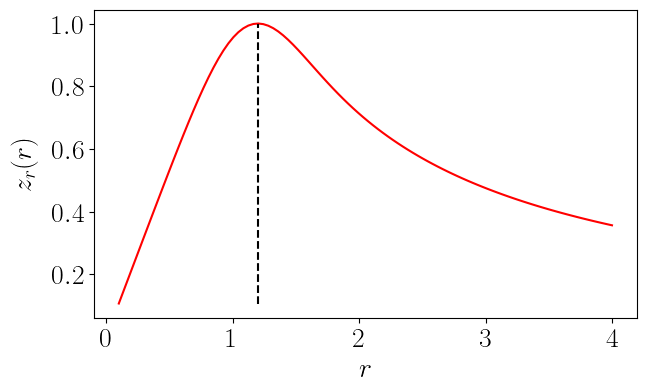

In [23]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(r_tab, z_r_tab, color='red')
ax.vlines(r_1, np.min(z_r_tab), 1.0, color='black', linestyle='dashed')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$z_r(r)$', labelpad=10);

# $N=1$, $R_1=1$, $\mathrm{sign}(a_1)=1$

In [24]:
r_1 = 1

σ_tab = [0.1, 0.2, 0.5, 0.75, 1.0, 3.0]
r_tab = np.linspace(0.1, 4, 100)
r_tab = np.linspace(0.1, 4, 100)
r_tab_bis = np.linspace(0.8, 1.2, 100)
z_r_tab = []
z_r_tab_bis = []

for σ in σ_tab:
    aux = compute_ab([r_1], [1], σ)
    a, b = aux[0], aux[1]
    
    η = lambda x: a*η1(x, r_1, σ) + b*η2(x, r_1, σ)
    z_r_tab_σ = []
    z_r_tab_σ_bis = []
    

    for r in r_tab:
        val, _ = quad(lambda ρ: ρ * η(np.array([ρ, 0])), 0, r)
        z_r_tab_σ.append(val / r)
        
    for r in r_tab_bis:
        val, _ = quad(lambda ρ: ρ * η(np.array([ρ, 0])), 0, r)
        z_r_tab_σ_bis.append(val / r)
        
    z_r_tab.append(z_r_tab_σ)
    z_r_tab_bis.append(z_r_tab_σ_bis)

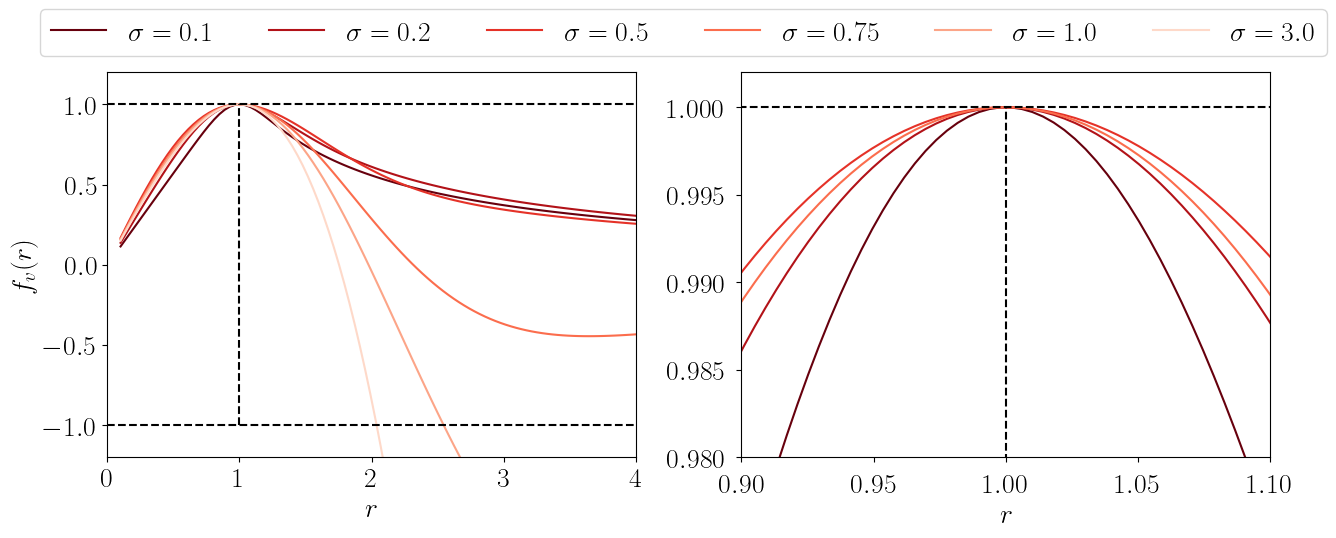

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors = pl.cm.Reds(np.linspace(0.15, 1, len(σ_tab)))

for i in range(len(z_r_tab)):
    ax1.plot(r_tab, z_r_tab[i], color=colors[len(σ_tab)-(i+1)], label=r'$\sigma={}$'.format(σ_tab[i]))
    
ax1.hlines(1.0, 0, np.max(r_tab), color='black', linestyle='dashed')
ax1.hlines(-1.0, 0, np.max(r_tab), color='black', linestyle='dashed')
ax1.vlines(1.0, -1.0, 1.0, color='black', linestyle='dashed')
ax1.set_ylim(-1.2, 1.2)
ax1.set_xlim(0, 4)
ax1.set_xlabel(r'$r$')
ax1.set_ylabel(r'$f_v(r)$')
ax1.legend(loc='upper center', bbox_to_anchor=(1.09, 1.2), fancybox=True, ncol=6)

for i in range(len(z_r_tab)-2):
    ax2.plot(r_tab_bis, z_r_tab_bis[i], color=colors[len(σ_tab)-(i+1)], label=r'$\sigma={}$'.format(σ_tab[i]))
    
ax2.hlines(1.0, 0.5, 1.5, color='black', linestyle='dashed')
ax2.vlines(1.0, -1.0, 1.0, color='black', linestyle='dashed')
ax2.set_xlim(0.9, 1.1)
ax2.set_ylim(0.98, 1.002)
ax2.set_xlabel(r'$r$')
ax2.tick_params(pad=8);

In [26]:
def grad_h(x, σ):
    return exp(-np.sum(x**2)/(2*σ**2)) * (-x) / σ**2

def grad_h_h(x, σ):
    return π*σ**2 * grad_h(x, sqrt(2)*σ)

def compute_normal_deriv(x, r, σ):
    a, b = compute_ab([r], [1], σ)
    
    e_r = x/np.linalg.norm(x)
    
    val1, _ = dblquad(lambda θ, ρ: np.dot(grad_h_h(x-np.array([ρ*cos(θ), ρ*sin(θ)]), σ), e_r) * ρ, 0, r, 0, 2*π)
    val2, _ = quad(lambda θ: np.dot(grad_h_h(x-np.array([r*cos(θ), r*sin(θ)]), σ), e_r), 0, 2*π)
    
    return a*val1 + b*r*val2

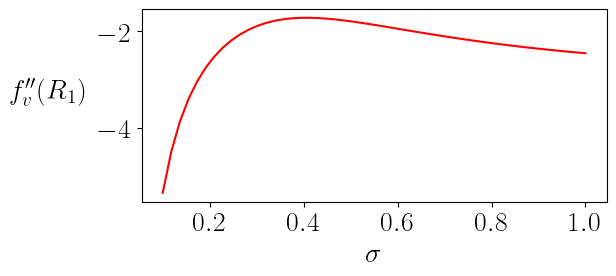

In [27]:
plt.figure(figsize=(6, 2.5))
σ_tab = np.linspace(0.1, 1)
norm_deriv_tab = np.array([compute_normal_deriv(np.array([0.0, 1.0]), 1.0, σ) for σ in σ_tab])
plt.plot(σ_tab, norm_deriv_tab+1, color='red')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$f^{\prime\prime}_v(R_1)$', rotation=0, labelpad=35);

# $\sigma=0.2$, $N=2$, $\mathrm{sign}(a_1)=-\mathrm{sign}(a_2)$, $R_1=1$, $R_2=1.5$ or $R_2=1.4$

In [28]:
r_1, r_2, r_2_bis = 1, 1.5, 1.4
ϵ_1, ϵ_2 = 1, -1
σ = 0.2

In [29]:
weights = compute_ab([r_1, r_2], [ϵ_1, ϵ_2], σ)
weights_bis = compute_ab([r_1, r_2_bis], [ϵ_1, ϵ_2], σ)

η = lambda x: weights[0] * η1(x, r_1, σ) + \
              weights[1] * η1(x, r_2, σ) + \
              weights[2] * η2(x, r_1, σ) + \
              weights[3] * η2(x, r_2, σ)
            
η_bis = lambda x: weights_bis[0] * η1(x, r_1, σ) + \
                  weights_bis[1] * η1(x, r_2_bis, σ) + \
                  weights_bis[2] * η2(x, r_1, σ) + \
                  weights_bis[3] * η2(x, r_2_bis, σ)

In [30]:
r_tab = np.linspace(0.1, 3, 100)
z_r_tab = []
z_r_tab_bis = []

for r in r_tab:
    val, _ = quad(lambda ρ: ρ * η(np.array([ρ, 0])), 0, r)
    z_r_tab.append(val / r)
    
for r in r_tab:
    val, _ = quad(lambda ρ: ρ * η_bis(np.array([ρ, 0])), 0, r)
    z_r_tab_bis.append(val / r)

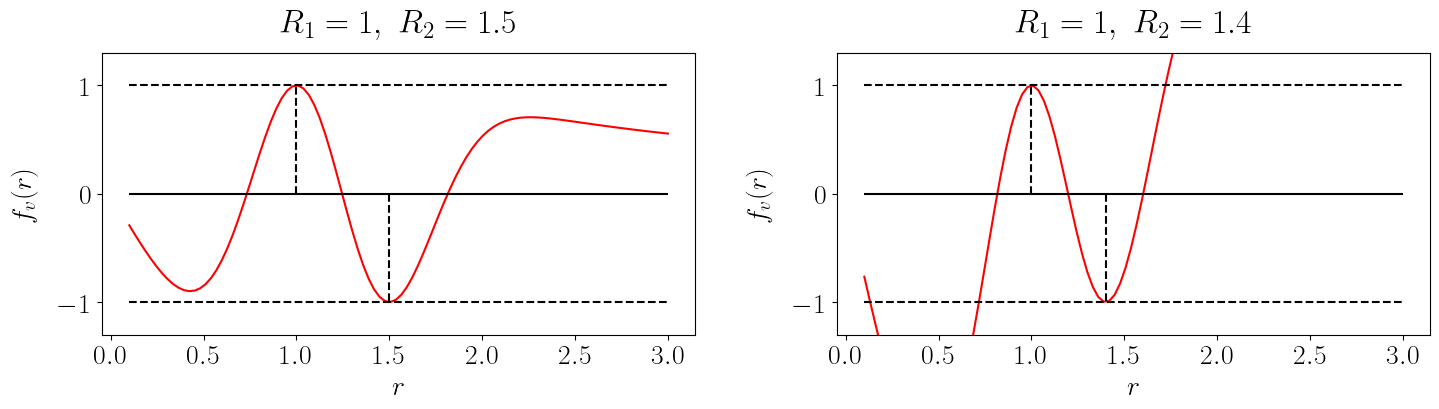

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4.5))

axs[0].plot(r_tab, z_r_tab, color='red')
axs[0].vlines(r_1, 0, ϵ_1, color='black', linestyle='dashed')
axs[0].vlines(r_2, 0, ϵ_2, color='black', linestyle='dashed')
axs[0].hlines(1.0, np.min(r_tab), np.max(r_tab), color='black', linestyle='dashed')
axs[0].hlines(-1.0, np.min(r_tab), np.max(r_tab), color='black', linestyle='dashed')
axs[0].hlines(0, np.min(r_tab), np.max(r_tab), color='black')
axs[0].set_xlabel(r'$r$')
axs[0].set_ylabel(r'$f_v(r)$', labelpad=15)
axs[0].set_title(r'$R_1=1,~R_2=1.5$', pad=15)
axs[0].set_ylim(-1.3, 1.3)

axs[1].plot(r_tab, z_r_tab_bis, color='red')
axs[1].vlines(r_1, 0, ϵ_1, color='black', linestyle='dashed')
axs[1].vlines(r_2_bis, 0, ϵ_2, color='black', linestyle='dashed')
axs[1].hlines(1.0, np.min(r_tab), np.max(r_tab), color='black', linestyle='dashed')
axs[1].hlines(-1.0, np.min(r_tab), np.max(r_tab), color='black', linestyle='dashed')
axs[1].hlines(0, np.min(r_tab), np.max(r_tab), color='black')
axs[1].set_xlabel(r'$r$')
axs[1].set_ylabel(r'$f_v(r)$', labelpad=15)
axs[1].set_title(r'$R_1=1,~R_2=1.4$', pad=15)
axs[1].set_ylim(-1.3, 1.3)

fig.tight_layout();

# $\sigma=0.2$, $N=2$, $\mathrm{sign}(a_1)=\mathrm{sign}(a_2)$, $R_1=1$, $R_2=1.1$

In [32]:
r_1, r_2 = 1, 1.1
ϵ_1, ϵ_2 = 1, 1
σ = 0.2

In [33]:
weights = compute_ab([r_1, r_2], [ϵ_1, ϵ_2], σ)
η = lambda x: weights[0]*η1(x, r_1, σ) + weights[1]*η1(x, r_2, σ) + weights[2] * η2(x, r_1, σ) + weights[3] * η2(x, r_2, σ)

In [34]:
r_tab = np.linspace(0.1, 3, 100)
r_tab_bis = np.linspace(0.9, 1.2, 100)
z_r_tab = []
z_r_tab_bis = []

for r in r_tab:
    val, _ = quad(lambda ρ: ρ * η(np.array([ρ, 0])), 0, r)
    z_r_tab.append(val / r)
    
for r in r_tab_bis:
    val, _ = quad(lambda ρ: ρ * η(np.array([ρ, 0])), 0, r)
    z_r_tab_bis.append(val / r)

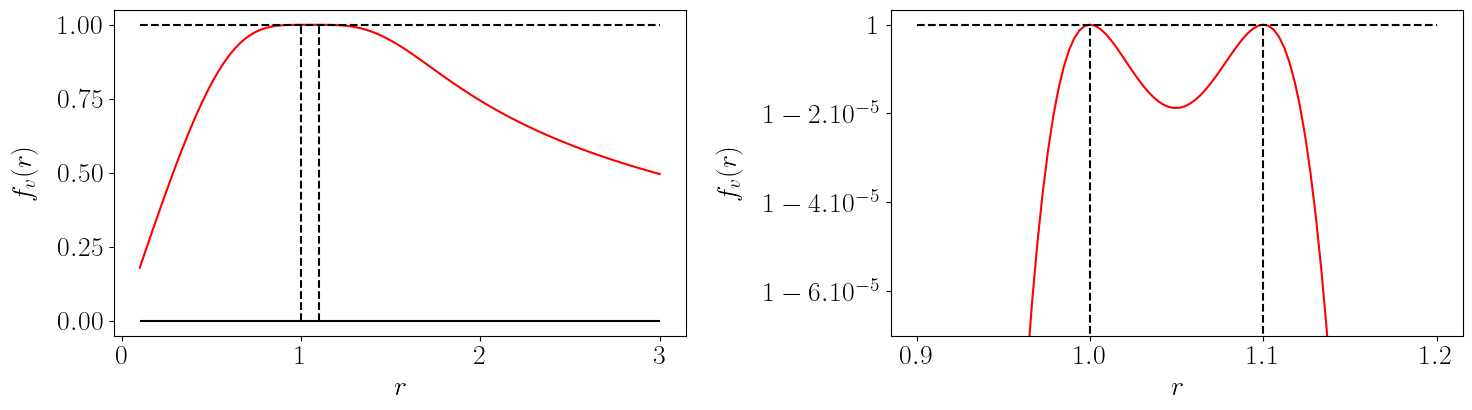

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4.5))

axs[0].plot(r_tab, z_r_tab, color='red')
axs[0].vlines(r_1, 0, ϵ_1, color='black', linestyle='dashed')
axs[0].vlines(r_2, 0, ϵ_2, color='black', linestyle='dashed')
axs[0].hlines(1.0, np.min(r_tab), np.max(r_tab), color='black', linestyle='dashed')
axs[0].hlines(0, np.min(r_tab), np.max(r_tab), color='black')
axs[0].set_xlabel(r'$r$')
axs[0].set_ylabel(r'$f_v(r)$', labelpad=15);

axs[1].plot(r_tab_bis, z_r_tab_bis, color='red')
axs[1].vlines(r_1, 0, ϵ_1, color='black', linestyle='dashed')
axs[1].vlines(r_2, 0, ϵ_2, color='black', linestyle='dashed')
axs[1].hlines(1.0, np.min(r_tab_bis), np.max(r_tab_bis), color='black', linestyle='dashed')
axs[1].hlines(0, np.min(r_tab_bis), np.max(r_tab_bis), color='black')
axs[1].set_xlabel(r'$r$')
axs[1].set_ylabel(r'$f_v(r)$', labelpad=15)
axs[1].set_ylim(1-7e-5, 1+3.3e-6)

fmt = lambda x, pos: r'$1{:.0f}.10^{{-5}}$'.format((x-1)*1e5, pos) if x<1-1e-6 else 1
axs[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmt))

fig.tight_layout();